## Prédiction de la valeur d'un vol avec le Boosting

Kaggle : https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction

Nous travaillerons avec les datasets brut, pas ceux travaillé par les personnes qui l'ont publié sur Kaggle. Il y aura deux datasets que l'on va utiliser ensemble.

In [1]:
import numpy as np
import pandas as pd


economy = pd.read_csv("economy.csv")
economy["Type"] = "Economy"

business = pd.read_csv("business.csv")
business["Type"] = "Business"

df = pd.concat((economy, business))
df.reset_index(inplace=True, drop=True)
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,Type
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy


## Exploration et nettoyage

Commençons par explorer les données. On veut s'assurer de la cohérence des données et identifier des variables qui pourraient être importante dans la modélisation.

**Consigne** : Modifier l'ensemble des noms de colonnes pour qu'ils commençent par une capitale. Puis supprimer les colonnes *Ch_code* et *Num_code*.

In [2]:
df.columns = [name.capitalize() for name in df.columns]
df = df.drop(columns=["Ch_code", "Num_code"], axis=1)
df.head()

,Date,Airline,Dep_time,From,Time_taken,Stop,Arr_time,To,Price,Type
0,11-02-2022,SpiceJet,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy


Les colonnes *Date*, *Dep_time*, *Time_taken* et *Arr_time* correspondent toute à des dates ou durée. Mettons-les au bon format.

### Travail des dates et des temps

**Consigne** : A l'aide de la fonction [`pd.to_datetime`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html), modifier la colonne *Date* puis créer la colonne *Flight_month* qui contient le mois du vol.

In [3]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df["Flight_month"] = df["Date"].dt.month

**Consigne** : Remplacer la colonne *Dep_time* par une colonne *Departure_hour* qui ne conserve que l'heure de départ. Faire de même avec la colonne *Arr_time* par *Arrival_hour*.

In [4]:
df["Departure_hour"] = df["Dep_time"].apply(lambda time: time[:2]).astype(int)
df["Arrival_hour"] = df["Arr_time"].apply(lambda time: time[:2]).astype(int)
df = df.drop(columns=["Dep_time", "Arr_time"], axis=1)

On souhaite également créer la colonne *Flight_time* à partir de la colonne *Time_taken* qui correspondra à la durée du vol en minutes.

In [5]:
import re

def convert_to_time(string_time):
    pattern = r'(\d+)h (\d+)m'
    match = re.match(pattern, string_time)
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
    else:
        hours, minutes = 0, 0
    return 60 * hours + minutes

df["Flight_time"] = df["Time_taken"].apply(lambda time: convert_to_time(time))
df = df.drop(columns=["Time_taken"], axis=1)

### Autre colonnes

**Consigne** : Explorer la colonne *Stop* et en extraire le nombre d'escale qui sont réalisés. La colonne sera catégorielle.

In [6]:
def convert_stop(stop_string):
    if stop_string == "non-stop ":
        stop = "0"
    elif stop_string == "2+-stop":
        stop = "2+"
    else:
        stop = "1"
    return stop

df["Stop"] = df["Stop"].apply(lambda stop: convert_stop(stop))
df.head()

,Date,Airline,From,Stop,To,Price,Type,Flight_month,Departure_hour,Arrival_hour,Flight_time
0,2022-02-11,SpiceJet,Delhi,0,Mumbai,"5,953",Economy,2,18,21,130
1,2022-02-11,SpiceJet,Delhi,0,Mumbai,"5,953",Economy,2,6,8,140
2,2022-02-11,AirAsia,Delhi,0,Mumbai,"5,956",Economy,2,4,6,130
3,2022-02-11,Vistara,Delhi,0,Mumbai,"5,955",Economy,2,10,12,135
4,2022-02-11,Vistara,Delhi,0,Mumbai,"5,955",Economy,2,8,11,140


**Consigne** : A l'aide de la méthode `info`, identifier puis corriger le problème de la colonne *Price*.

In [7]:
df["Price"] = df["Price"].apply(lambda string: string.replace(',', '')).astype(int)

**Consigne** : Remplacer la variable *Type* par une valeur 0 ou 1 (pour business). On modifiera le nom de la colonne en conséquence.

In [8]:
df["Business_Flight"] = df["Type"].apply(lambda flight_type: flight_type == "Business").astype(np.uint8)
df = df.drop(columns=["Type"], axis=1)

**Consigne** : Afficher la représentativité de chaque compagnie aérienne. Faire de même avec les colonnes *From* et *To* puis commenter.

In [9]:
df["Airline"].value_counts() / df.shape[0] * 100

Vistara      42.582620
Air India    26.941228
Indigo       14.360839
GO FIRST      7.718951
AirAsia       5.361336
SpiceJet      3.001056
StarAir       0.020316
Trujet        0.013655
Name: Airline, dtype: float64

In [10]:
df["From"].value_counts() / df.shape[0] * 100

Delhi        20.430559
Mumbai       20.283353
Bangalore    17.353569
Kolkata      15.435571
Hyderabad    13.608161
Chennai      12.888787
Name: From, dtype: float64

In [11]:
df["To"].value_counts() / df.shape[0] * 100

Mumbai       19.685873
Delhi        19.103713
Bangalore    17.022524
Kolkata      16.497314
Hyderabad    14.246272
Chennai      13.444303
Name: To, dtype: float64

**Consigne** : A la lumière des observations précédentes, réaliser un One-Hot-Encoding avec la fonction [`pd.get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html).

In [12]:
df = pd.get_dummies(df, columns=["Airline", "From", "To", "Stop"])
df = df.drop(columns=["Airline_SpiceJet", "Airline_StarAir", "Airline_Trujet"], axis=1)
df.head()

,Date,Price,Flight_month,Departure_hour,Arrival_hour,Flight_time,Business_Flight,Airline_Air India,Airline_AirAsia,Airline_GO FIRST,...,From_Mumbai,To_Bangalore,To_Chennai,To_Delhi,To_Hyderabad,To_Kolkata,To_Mumbai,Stop_0,Stop_1,Stop_2+
0,2022-02-11,5953,2,18,21,130,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,2022-02-11,5953,2,6,8,140,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,2022-02-11,5956,2,4,6,130,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
3,2022-02-11,5955,2,10,12,135,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,2022-02-11,5955,2,8,11,140,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


**Consigne** : Trier la totalité du dataset par la colonne *Date* avec la méthode `sort_values` puis supprimer la colonne *Date*. On prendra soin d'avoir une réindexation du dataset.

In [13]:
df.sort_values(by="Date", inplace=True, ignore_index=True)
df = df.drop(columns=["Date"], axis=1)

## Modélisation

Puisque nous avons un dataset indexé par le temps, nous ne pouvons pas faire de coupure aléatoire.

**Consigne** : Ecrire une fonction `split_time_dataset` qui prend en paramètre
* *X* : une matrice
* *y* : un vecteur
* *train_ratio* : proportion d'observation à placer dans le dataset d'entraînement
La fonction renverra un tuple de même format que la fonction [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) de scikit-learn.

In [14]:
def split_time_dataset(X, y, train_ratio):
    assert X.shape[0] == len(y)
    
    n = X.shape[0]
    index = round(n * train_ratio)
    
    X_train, X_test= X.iloc[:index, ], X.iloc[index:, ]
    y_train, y_test = y[:index], y[index:]
    
    return X_train, X_test, y_train, y_test

**Consigne** : A l'aide la fonction précédente, générer un dataset d'entraînement composé de 75% des observations.

In [15]:
X = df.drop(columns=["Price"], axis=1)
y = df["Price"]

X_train, X_test, y_train, y_test = split_time_dataset(X, y, train_ratio=0.75)

On décide de travailler avec le modèle LightGBM.

**Consigne** : Construire un modèle avec 50 arbres, puis l'entraîner et calculer le vecteur prédit pour le dataset de test.

In [16]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(n_estimator=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

**Consigne** : Construire une fonction `print_performance` qui prend en paramètre un vecteur *y_true* et un vecteur *y_pred* et qui calcule, puis affiche, la valeur de la RMSE et du R2. Pour aider à l'interprétation, on affichera également la valeur moyenne du vecteur *y_test*.

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

RMSE = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
def print_performance(y_true, y_pred):
    print(f"RMSE: {RMSE(y_true, y_pred):.2f}")
    print(f"Moyenne des prix: {y_true.mean():.2f}")
    print(f"R2: {r2_score(y_true, y_pred):.4f}")

print_performance(y_true=y_test, y_pred=y_pred)

RMSE: 3239.79
Moyenne des prix: 18992.96
R2: 0.9794


On sait que les prix sont plus élevés pour les vols business. On veut savoir si le modèle est aussi performant sur les deux types de billet.

**Consigne** : Créer un dataset *result* qui correspond au dataset de test et à l'ajout de la prédiction et du vrai prix.

In [18]:
result = X_test.copy()
result["y_true"] = y_test
result["y_pred"] = y_pred
result.head()

,Flight_month,Departure_hour,Arrival_hour,Flight_time,Business_Flight,Airline_Air India,Airline_AirAsia,Airline_GO FIRST,Airline_Indigo,Airline_Vistara,...,To_Chennai,To_Delhi,To_Hyderabad,To_Kolkata,To_Mumbai,Stop_0,Stop_1,Stop_2+,y_true,y_pred
225196,3,8,19,675,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,47395,52635.615631
225197,3,21,8,660,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,47395,46353.618253
225198,3,12,19,410,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,47395,53176.641897
225199,3,13,23,650,1,1,0,0,0,0,...,0,1,0,0,0,0,1,0,44583,44345.233557
225200,3,13,20,450,1,1,0,0,0,0,...,0,1,0,0,0,0,1,0,44583,44667.034785


**Consigne** : Calculer la performance du modèle selon le type de billet. Commenter.

In [19]:
for (flight_type, value) in zip(["Economique", "Business"], [0, 1]):
    y_pred = np.array(result.loc[result["Business_Flight"] == value, "y_pred"])
    y_true = np.array(result.loc[result["Business_Flight"] == value, "y_true"])
    print(f"Billet {flight_type}")
    print_performance(y_true=y_true, y_pred=y_pred)
    print()

Billet Economique
RMSE: 1455.07
Moyenne des prix: 4848.31
R2: 0.4741

Billet Business
RMSE: 5455.56
Moyenne des prix: 51517.37
R2: 0.8028



## Effet du learning rate

In [20]:
performances = []
learning_rates = [10**(-power) for power in range(0, 5)]
for learning_rate in learning_rates:
    model = LGBMRegressor(n_estimators=50, learning_rate=learning_rate)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    performances.append(RMSE(y_test, y_pred))

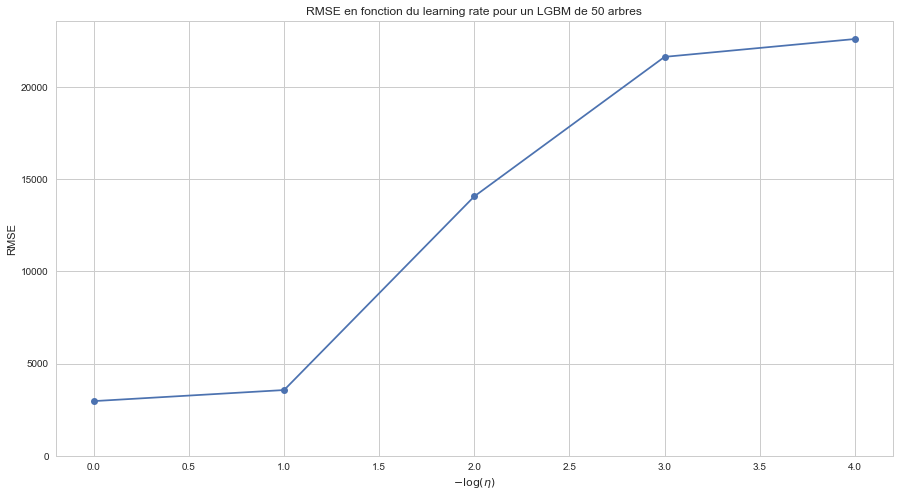

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

plt.figure(figsize=(15, 8))
plt.plot(-np.log(learning_rates)/np.log(10), performances, 'o-')
plt.xlabel(r"$-\log(\eta)$")
plt.ylabel("RMSE")
plt.ylim(bottom=0)
plt.title("RMSE en fonction du learning rate pour un LGBM de 50 arbres")
plt.show()

**Consigne**: Faire la même chose avec un LGBM de 100 arbres et un autre de 250, puis afficher le résultats avec le précédent.

In [22]:
performances = []
learning_rates = [10**(-power) for power in range(0, 5)]
for n_estimators in [50, 100, 250]:
    performance = []
    for learning_rate in learning_rates:
        model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        performance.append(RMSE(y_test, y_pred))
    performances.append({"Trees": n_estimators, "performances": performance})

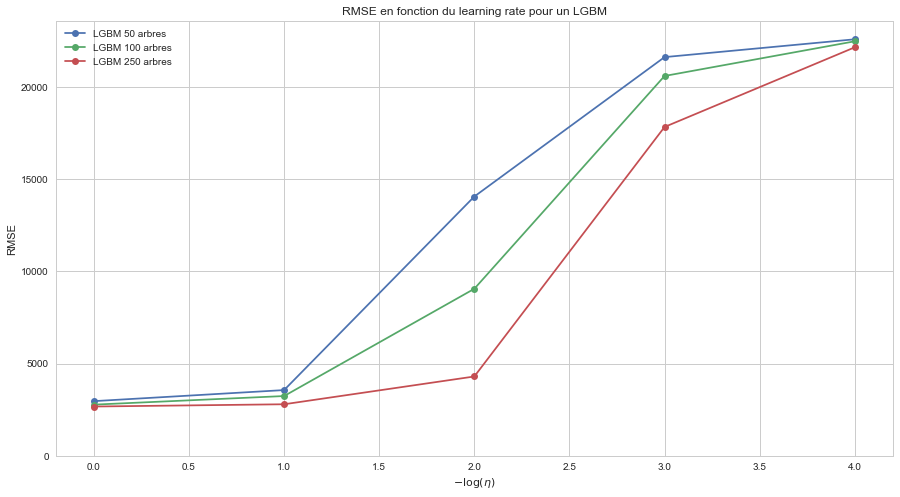

In [23]:
plt.figure(figsize=(15, 8))
for element in performances:
    n_estimators = element["Trees"]
    plt.plot(-np.log(learning_rates)/np.log(10), element["performances"], 'o-', label=f"LGBM {n_estimators} arbres")

plt.xlabel(r"$-\log(\eta)$")
plt.ylabel("RMSE")
plt.ylim(bottom=0)
plt.title("RMSE en fonction du learning rate pour un LGBM")
plt.legend()
plt.show()

On souhaiterai avoir une vision du sur-apprentissage. Pour ce faire, nous allons mesurer l'écart entre les performances sur le dataset d'entraînement et celui de test.

**Consigne** : Reproduire le graphique précédent en ajoutant l'information de la performance sur le jeu d'entraînement.

In [24]:
performances = []
learning_rates = [10**(-power) for power in range(0, 5)] + [5 * 10**(-power) for power in range(1, 5)]
learning_rates.sort()
for n_estimators in [50, 100, 250]:
    performance_train = []
    performance_test = []
    for learning_rate in learning_rates:
        model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_train)
        performance_train.append(RMSE(y_train, y_pred))
        
        y_pred = model.predict(X_test)
        performance_test.append(RMSE(y_test, y_pred))
        
    performances.append({"Trees": n_estimators,
                         "performances_train": performance_train,
                         "performances_test": performance_test})

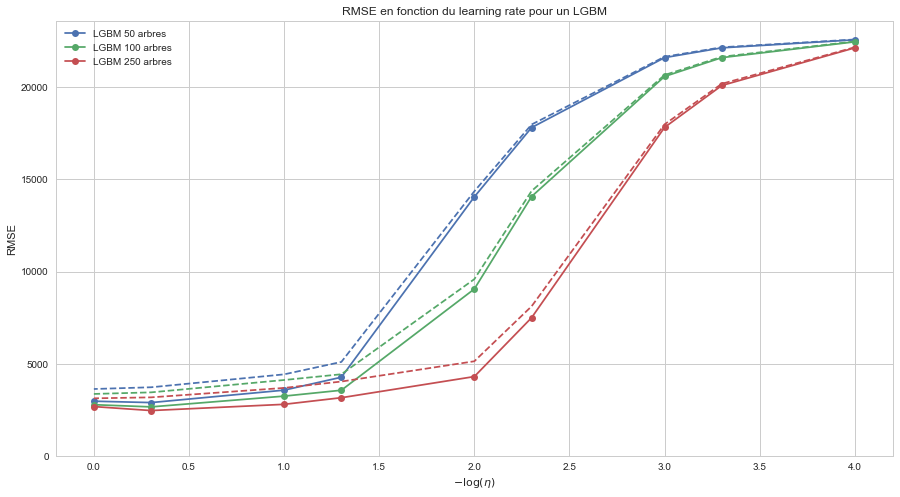

In [25]:
plt.figure(figsize=(15, 8))
for index, element in enumerate(performances):
    color = sns.color_palette()[index]
    n_estimators = element["Trees"]
    powers = -np.log(learning_rates)/np.log(10)
    plt.plot(powers, element["performances_test"], 'o-', label=f"LGBM {n_estimators} arbres", color=color)
    plt.plot(powers, element["performances_train"], '--', color=color)
    

plt.xlabel(r"$-\log(\eta)$")
plt.ylabel("RMSE")
plt.ylim(bottom=0)
plt.title("RMSE en fonction du learning rate pour un LGBM")
plt.legend()
plt.show()

## Régularisation : par la profondeur

Il y a un sur-apprentissage légé, et on voudrait pour le réduire. Il existe plusieurs possibilités pour cela, mais nous allons nous concentrer sur la profondeur maximale d'un arbre *max_depth*.

On considère dans la suite un modèle avec 250 arbres, et des learning rates entre $10^{-2}$ et $1$. Puisque nous allons reproduire plusieurs fois des cellules de codes similaires, commençons par en faire une fonction.

**Consigne** : Compléter la fonction `compute_performance` qui prend en paramètres:
* *learning_rates*: une liste de learning rates à tester
* *parameter_name*: le nom du paramètre du modèle que l'on souhaite tester
* *parameter_vales*: une liste de valeur à tester pour le paramètre d'intérêt

In [26]:
def compute_performance(learning_rates, parameter_name, parameter_values, **parameters):
    performances = []
    learning_rates.sort()
    
    for parameter_value in parameter_values:
        performance_train = []
        performance_test = []
        for learning_rate in learning_rates:
            parameters["learning_rate"] = learning_rate
            parameters[parameter_name] = parameter_value
            model = LGBMRegressor(**parameters)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_train)
            performance_train.append(RMSE(y_train, y_pred))

            y_pred = model.predict(X_test)
            performance_test.append(RMSE(y_test, y_pred))

        performances.append({parameter_name: parameter_value,
                             "performances_train": performance_train,
                             "performances_test": performance_test})
        
    return performances

Il nous faut maintenant de la visualisation. On utilisera la fonction `plot_performance` ci-dessous.

**Consigne**: À l'aide la fonction `compute_performance` et de la fonction `plot_performance`, visualiser l'impact de la profondeur des arbres en fonction du learning rate.

In [27]:
def plot_performance(performances, learning_rates, parameter_name):
    plt.figure(figsize=(15, 8))
    for index, element in enumerate(performances):
        color = sns.color_palette()[index]
        parameter_value = element[parameter_name]
        powers = -np.log(learning_rates)/np.log(10)
        plt.plot(powers, element["performances_test"], 'o-', label=f"{parameter_name} = {parameter_value}", color=color)
        plt.plot(powers, element["performances_train"], '--', color=color)


    plt.xlabel(r"$-\log(\eta)$")
    plt.ylabel("RMSE")
    plt.ylim(bottom=0)
    plt.title(f"RMSE en fonction du paramètre {parameter_name} pour un LGBM")
    plt.legend()
    plt.show()

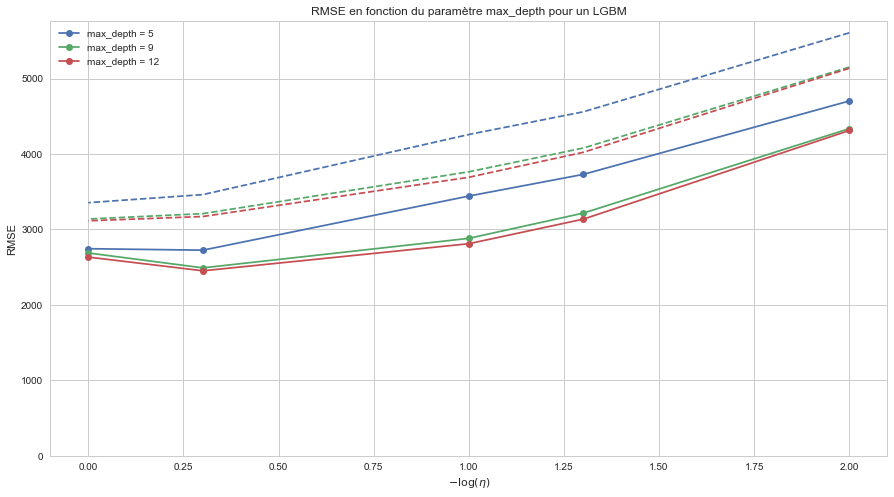

In [28]:
learning_rates = [10**(-power) for power in range(0, 3)] + [5 * 10**(-power) for power in range(1, 3)]
learning_rates.sort()

performances = compute_performance(learning_rates=learning_rates,
                                   parameter_name="max_depth",
                                   parameter_values=[5, 9, 12],
                                   n_estimators=250
                                  )

plot_performance(performances, learning_rates, "max_depth")

## Importance des features

On se pose la question de l'importance de chacune des informations que l'on a donné au modèle. Pour le faire, on doit d'abord entraîner un modèle.

**Consigne** : Avec l'étude préalable, entraîner un modèle avec les  paramètre de votre choix.

In [29]:
model = LGBMRegressor(n_estimators=250, learning_rate=0.5, max_depth=9)
model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.5, max_depth=9, n_estimators=250)

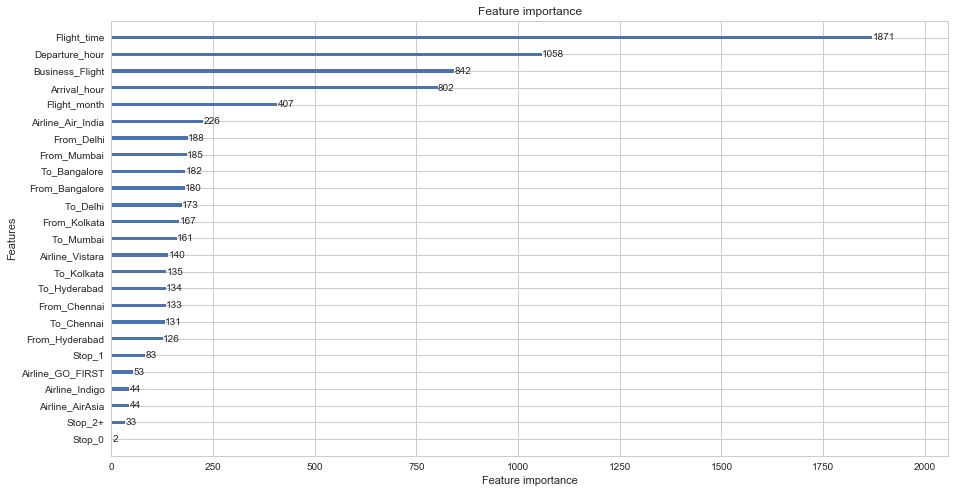

In [30]:
from lightgbm import plot_importance

plot_importance(model, figsize=(15, 8))
plt.show()